# Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel1, SampleModel2, SampleModel3
from dissipationtheory.dissipation9b import SampleModel1Jit, SampleModel2Jit, SampleModel3Jit

In [3]:
from dissipationtheory.dissipation13e import twodimCobject

In [4]:
THIS = 'dissipation-theory--Study-65--'
figs = {}
obj = {}
results = {}

# Frequency and friction versus height

Representative cantilever and sample parameters from `2025-07-11--jam99--20240222-rerun-ringdown-NiOx-U551--Study-2.ipynb`.

In [5]:
cantilever = CantileverModel(
    f_c = ureg.Quantity(60.360, 'kHz'),
    k_c = ureg.Quantity(2.8, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(57, 'nm'),
    angle = ureg.Quantity(24.2, 'degree'),
    L = ureg.Quantity(2250, 'nm'))

## Type III sample

In [6]:
sample3 = SampleModel3(
    cantilever = cantilever,
    epsilon_s = ureg.Quantity(complex(18.2, 0), ''),
    sigma = ureg.Quantity(9.7e-7, 'S/cm'),
    rho = ureg.Quantity(1.9e15, '1/cm^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample3_jit = SampleModel3Jit(**sample3.args())

Set up the finite tip object and calculate all possible properties.

In [7]:
%%time

obj['III'] = twodimCobject(sample3_jit)
obj['III'].addtip(h=ureg.Quantity(37.5, 'nm'))
obj['III'].set_alpha(1.0e-6)
obj['III'].set_breakpoints(15)
obj['III'].properties_dc()
obj['III'].properties_ac(omega_m=1.0e5)
obj['III'].properties_am(omega_m=1.0e5, omega_am = 250.)

CPU times: user 5.72 s, sys: 159 ms, total: 5.88 s
Wall time: 5.83 s


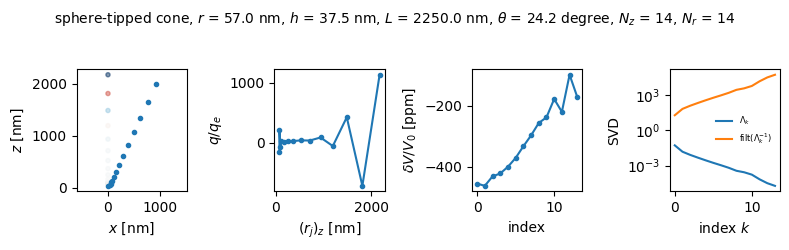

In [8]:
figs['03'] = obj['III'].plot()

All available results.

In [9]:
obj['III'].results

{'Vts [V]': 1.0,
 'alpha': 1e-06,
 'breakpoints': 15,
 'q': array([-150.66177219,  222.1035354 ,  -73.52062161,   38.50160251,
          13.95413978,   27.02601059,   31.94464646,   43.0491714 ,
          40.44472561,   90.76229447,  -50.64725354,  425.81969079,
        -710.30297074, 1129.65149228]),
 'S': array([5.28536079e-02, 1.52494643e-02, 8.21451570e-03, 4.78284534e-03,
        2.84387267e-03, 1.73153910e-03, 1.08289240e-03, 6.60864674e-04,
        3.68552719e-04, 2.75367094e-04, 1.73076590e-04, 6.95895969e-05,
        3.26981384e-05, 1.93432316e-05]),
 'Sinv': array([1.89201843e+01, 6.55760737e+01, 1.21735720e+02, 2.09080555e+02,
        3.51633140e+02, 5.77520695e+02, 9.23451995e+02, 1.51316563e+03,
        2.71329605e+03, 3.63146808e+03, 5.77759601e+03, 1.43669972e+04,
        3.05542033e+04, 5.15598683e+04]),
 'cn': 2732.4083631668636,
 'V': array([0.99954498, 0.99953733, 0.99956825, 0.99957787, 0.99959978,
        0.99962872, 0.99966673, 0.99970243, 0.99974324, 0.99976158,


Key results.

In [10]:
obj['III'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
             alpha       0.000    +1.000000e-06
       breakpoints      15.000    +1.500000e+01
           C0 [aF]     173.009    +1.730089e+02
         C1 [pF/m]    -121.493    -1.214930e+02
       C2 [mF/m^2]       1.939    +1.938518e+00
    gamma [pN s/m]      49.683    +4.968302e+01
   Delta f dc [Hz]     -10.235    -1.023527e+01
   Delta f ac [Hz]      -5.181    -5.181191e+00
   Delta f am [Hz]      -1.943    -1.942947e+00
--------------------------------------------------


Array of heights similar to experiment. \
The experiment had 27 points.

In [11]:
h_array = np.logspace(np.log10(20), np.log10(200), 25)

In [74]:
len(h_array)

25

Loop over heights and compute dc frequency shift and friction.

In [12]:
%%time

f2_calc = {}
gamma_calc = {}

f2_calc['III'] = np.zeros_like(h_array)
gamma_calc['III'] = np.zeros_like(h_array)
_obj = {}

for index, h in enumerate(h_array):
       
    _obj[index] = twodimCobject(sample3_jit)
    _obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    _obj[index].set_alpha(1.0e-6)
    _obj[index].set_breakpoints(15)
    _obj[index].properties_dc()
    
    f2_calc['III'][index] = _obj[index].results['Delta f dc [Hz]']
    gamma_calc['III'][index] = _obj[index].results['gamma [pN s/m]']

CPU times: user 1.96 s, sys: 307 ms, total: 2.27 s
Wall time: 1.2 s


Store the findings in a pandas dataframe to plot. \
To develop the plotting program below, create a second dataset with the key `'expt'`.

In [13]:
df = {}

df['III'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['III']),
     'gamma [pN s/m]': gamma_calc['III']})

df['expt'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['III']),
     'gamma [pN s/m]': gamma_calc['III']})

Create a parallel set of plot annotations.

In [14]:
annotations = {}

annotations['III'] = {
    'args': dict(color='black',
                 linestyle='-',
                 label='Type III')}

annotations['expt'] = {
    'args': dict(color='blue',
                 marker='o',
                 linestyle='none',
                 markerfacecolor='none', 
                 markersize=6,
                 label='Type III also')}

A function for jointly plotting frequency shift and friction versus height.

In [15]:
def plotme(annotations, df, keys=None, Vts=1.00, ax2yscale='linear', gamma0=0.):

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=((6.50,3.5)))
    
    if keys is None:
        keys = df.keys()
        
    for key in keys:
            
        args = annotations[key]['args']
        
        x1 = df[key]['h [nm]']
        y1 = df[key]['Delta f dc [Hz]'] / Vts**2
            
        ax1.plot(x1, y1, **args)
        ax1.set_xlabel('tip-sample separation $h$ [nm]')
        ax1.set_ylabel('frequency $\Delta f_2$ [Hz V$^{-2}$]')
        ax1.legend(frameon=False, fontsize=9)
        ax1.set_xscale('log')
        ax1.set_yscale('log')

        x1 = df[key]['h [nm]']
        y1 = (df[key]['gamma [pN s/m]'] + gamma0) / Vts**2        
        
        ax2.plot(x1, y1, **args)
        ax2.set_xlabel('tip-sample separation $h$ [nm]')    
        ax2.set_ylabel('friction $\Gamma_2$ [pN s m$^{-1}$ V$^{-2}$]')
        ax2.legend(frameon=False, fontsize=9)
        ax2.set_xscale('log')
        ax2.set_yscale(ax2yscale)
        
    fig.tight_layout()
    
    return fig

Loop over all the keys.

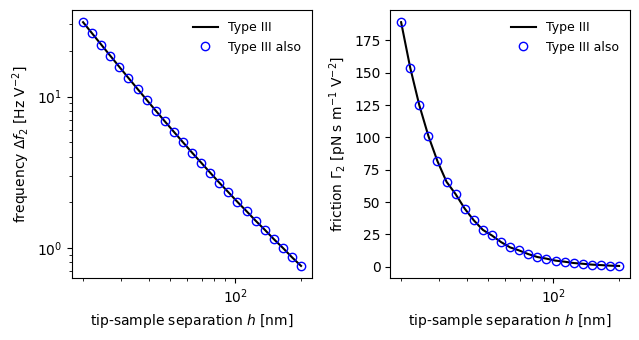

In [16]:
_ = plotme(annotations, df)

Just plot one set.

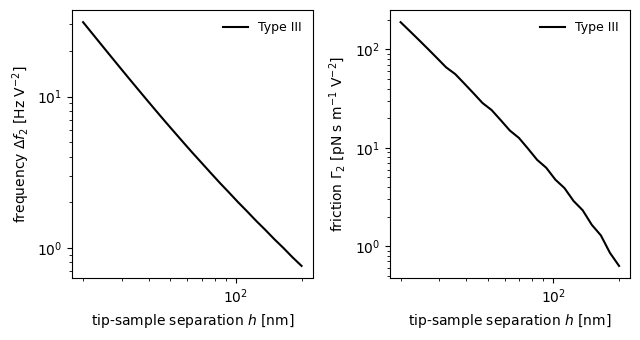

In [17]:
_ = plotme(annotations, df, ['III'], ax2yscale='log')

## Type II sample

Sample `II` is a semi-infinite semiconductor with a dielectric overlayer of thickness 100 nm and relative dielectric constant 1. \
The underlying semi-infinite semiconductor has the same properties as sample `III`.

In [18]:
sample2 = SampleModel2(
    cantilever = cantilever,
    h_d = ureg.Quantity(100, 'nm'),
    epsilon_d = ureg.Quantity(complex(1, 0), ''),
    epsilon_s = ureg.Quantity(complex(18.2, 0), ''),
    sigma = ureg.Quantity(9.7e-7, 'S/cm'),
    rho = ureg.Quantity(1.9e15, '1/cm^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample2_jit = SampleModel2Jit(**sample2.args())

In [19]:
%%time

obj['II'] = twodimCobject(sample2_jit)
obj['II'].addtip(h=ureg.Quantity(37.5, 'nm'))
obj['II'].set_alpha(1.0e-6)
obj['II'].set_breakpoints(15)
obj['II'].properties_dc()
obj['II'].properties_ac(omega_m=1.0e5)
obj['II'].properties_am(omega_m=1.0e5, omega_am = 250.)

CPU times: user 2.47 s, sys: 119 ms, total: 2.59 s
Wall time: 2.28 s


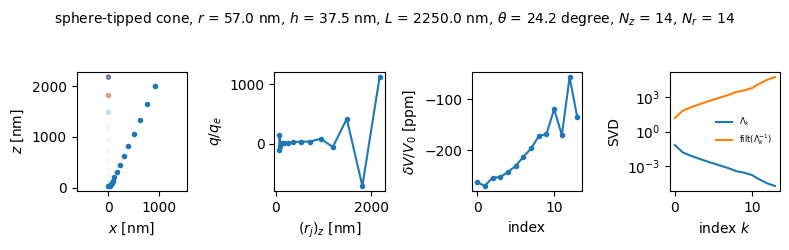

In [20]:
figs['02'] = obj['II'].plot()

In [21]:
obj['II'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
             alpha       0.000    +1.000000e-06
       breakpoints      15.000    +1.500000e+01
           C0 [aF]     165.117    +1.651169e+02
         C1 [pF/m]     -57.603    -5.760260e+01
       C2 [mF/m^2]       0.245    +2.446101e-01
    gamma [pN s/m]       2.127    +2.126795e+00
   Delta f dc [Hz]      -1.294    -1.294419e+00
   Delta f ac [Hz]      -0.654    -6.544335e-01
   Delta f am [Hz]      -0.245    -2.454125e-01
--------------------------------------------------


In [22]:
%%time

f2_calc['II'] = np.zeros_like(h_array)
gamma_calc['II'] = np.zeros_like(h_array)
_obj = {}

for index, h in enumerate(h_array):
       
    _obj[index] = twodimCobject(sample2_jit)
    _obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    _obj[index].set_alpha(1.0e-6)
    _obj[index].set_breakpoints(15)
    _obj[index].properties_dc()
    
    f2_calc['II'][index] = _obj[index].results['Delta f dc [Hz]']
    gamma_calc['II'][index] = _obj[index].results['gamma [pN s/m]']

CPU times: user 2.62 s, sys: 387 ms, total: 3.01 s
Wall time: 1.72 s


Create a second dataset, `IIb`, that is the Type II data but plotted as the effective distance $h_{\mathrm{d}} = 100$ nm from the semi-infinite part of the sample.
This dataset, when plotted, should lie on top of the `III` dataset. 

In [23]:
df['II'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['II']),
     'gamma [pN s/m]': gamma_calc['II']})

df['IIb'] = pd.DataFrame(
    {'h [nm]': h_array + 100,
     'Delta f dc [Hz]': np.abs(f2_calc['II']),
     'gamma [pN s/m]': gamma_calc['II']})

In [24]:
df['II']

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.000000,1.581024,3.127026
1,22.013883,1.540578,2.931543
2,24.230553,1.497935,2.730436
3,26.670429,1.453122,2.524747
4,29.355985,1.406193,2.315694
5,32.311962,1.357226,2.104659
6,35.565588,1.322996,2.253965
7,39.146836,1.270849,2.023914
8,43.088694,1.217094,1.796187
9,47.427474,1.161915,1.572703


In [25]:
annotations['II'] = {
    'args': dict(color='blue',
                 linestyle='--',
                 label='Type II')}

annotations['IIb'] = {
    'args': dict(color='blue',
                 marker='.',
                 linestyle='none',
                 markerfacecolor='none', 
                 markersize=6,
                 label='Type II shifted')}

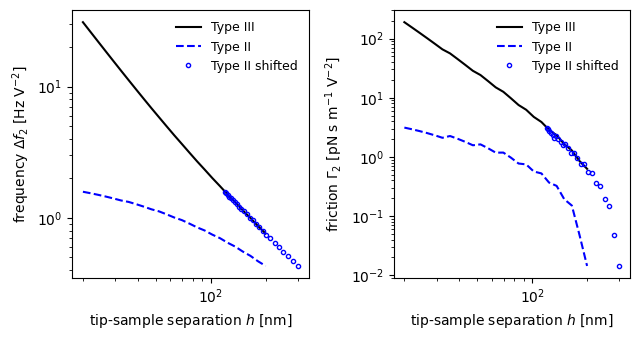

In [26]:
_ = plotme(annotations, df, ['III', 'II', 'IIb'], ax2yscale='log')

Neato.

## Type I sample

To exhibit a finite-thickness effect, we need the sample to be thinner than the Debye length.

In [27]:
print('Sample III Debye length = {:0.1f}'.format(1/sample3.kD))

Sample III Debye length = 27.4 nanometer


Sample `I` is an $h_{\mathrm{s}} = 15$ nm thick semiconductor atop a semi-infinite metal (relative dielectric constant $\epsilon_\mathrm{d} = 10^{6}$). \
The semiconductor has the same properties as sample `III`.

In [28]:
sample1 = SampleModel1(
    cantilever = cantilever,
    h_s = ureg.Quantity(15, 'nm'),
    epsilon_s = ureg.Quantity(complex(18.2, -0.1), ''),
    epsilon_d = ureg.Quantity(complex(1e6, 0), ''),
    sigma = ureg.Quantity(9.7e-7, 'S/cm'),
    rho = ureg.Quantity(1.9e15, '1/cm^3'),
    z_r = ureg.Quantity(1, 'nm'))

sample1_jit = SampleModel1Jit(**sample1.args())

In [29]:
%%time

obj['I'] = twodimCobject(sample1_jit)
obj['I'].addtip(h=ureg.Quantity(200, 'nm'))
obj['I'].set_alpha(1.0e-6)
obj['I'].set_breakpoints(15)
obj['I'].properties_dc()
obj['I'].properties_ac(omega_m=1.0e5)
obj['I'].properties_am(omega_m=1.0e5, omega_am = 250.)

CPU times: user 4.05 s, sys: 294 ms, total: 4.34 s
Wall time: 3.46 s


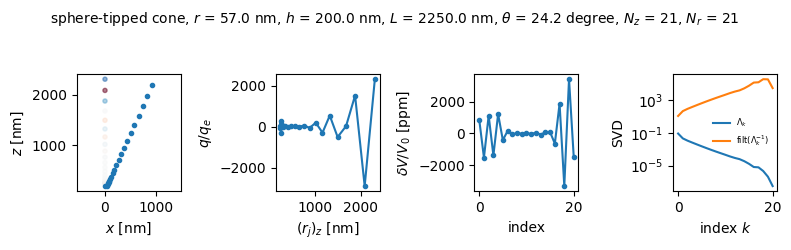

In [30]:
figs['01'] = obj['I'].plot()

In [31]:
obj['I'].print_key_results()

--------------------------------------------------
           Vts [V]       1.000    +1.000000e+00
             alpha       0.000    +1.000000e-06
       breakpoints      15.000    +1.500000e+01
           C0 [aF]     166.627    +1.666275e+02
         C1 [pF/m]     -47.292    -4.729193e+01
       C2 [mF/m^2]       0.149    +1.485603e-01
    gamma [pN s/m]      -0.001    -9.080206e-04
   Delta f dc [Hz]      -0.801    -8.006299e-01
   Delta f ac [Hz]      -0.400    -4.003110e-01
   Delta f am [Hz]      -0.150    -1.501166e-01
--------------------------------------------------


In [32]:
%%time

f2_calc['I'] = np.zeros_like(h_array)
gamma_calc['I'] = np.zeros_like(h_array)
_obj = {}

for index, h in enumerate(h_array):
       
    _obj[index] = twodimCobject(sample1_jit)
    _obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    _obj[index].set_alpha(1.0e-6)
    _obj[index].set_breakpoints(15)
    _obj[index].properties_dc()
    
    f2_calc['I'][index] = _obj[index].results['Delta f dc [Hz]']
    gamma_calc['I'][index] = _obj[index].results['gamma [pN s/m]']

CPU times: user 6.29 s, sys: 1.09 s, total: 7.37 s
Wall time: 3.95 s


In [33]:
df['I'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['I']),
     'gamma [pN s/m]': gamma_calc['I']})

In [34]:
df['I']

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.000000,38.654420,-0.043825
1,22.013883,32.234286,-0.056497
2,24.230553,26.898737,-0.060437
3,26.670429,22.465404,-0.059083
4,29.355985,18.781915,-0.054749
5,32.311962,15.721085,-0.048961
6,35.565588,13.196793,-0.042520
7,39.146836,11.081987,-0.036377
8,43.088694,9.321883,-0.030665
9,47.427474,7.855514,-0.025549


Why is the friction negative in Sample `I`?

In [35]:
annotations['I'] = {
    'args': dict(color='green',
                 linestyle='-.',
                 label='Type I ({:0.0f} nm)'.format(sample1.h_s.to('nm').magnitude))}

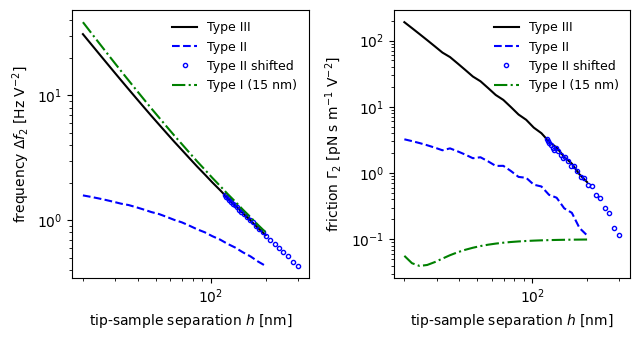

In [36]:
figs['04'] = plotme(annotations, df,
                    ['III', 'II', 'IIb', 'I'],
                    ax2yscale='log',
                    gamma0=0.1)

The friction for the `I` sample is actually negative, and more negative closer to the sample.  To display this friction in the plot, which has a logarithmic scale, we have added a small amount to this friction, 0.1 pN s/m, to make it net positive.

Run a Sample `I` calculation with the number of integration breakpoints increased from 15 to 45.

In [37]:
%%time

f2_calc['Ib'] = np.zeros_like(h_array)
gamma_calc['Ib'] = np.zeros_like(h_array)
_obj = {}

for index, h in enumerate(h_array):
       
    _obj[index] = twodimCobject(sample1_jit)
    _obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    _obj[index].set_alpha(1.0e-6)
    _obj[index].set_breakpoints(45) # increase from 15
    _obj[index].properties_dc()
    
    f2_calc['Ib'][index] = _obj[index].results['Delta f dc [Hz]']
    gamma_calc['Ib'][index] = _obj[index].results['gamma [pN s/m]']
    
df['Ib'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['Ib']),
     'gamma [pN s/m]': gamma_calc['Ib']})

CPU times: user 13.4 s, sys: 1.98 s, total: 15.4 s
Wall time: 8.35 s


We see that increasing the number of breakpoints does not change the small friction at all. \
The friction error is therefore likely *not caused by inaccurate numerical integration*.

In [38]:
pd.concat([df['I'].head(1), 
           df['I'].tail(1)])

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.0,38.65442,-0.043825
24,200.0,0.80063,-0.000908


In [39]:
pd.concat([df['Ib'].head(1), 
           df['Ib'].tail(1)])

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.0,38.65442,-0.043825
24,200.0,0.80063,-0.000908


Run a Sample `I` calculation with the $\alpha$ parameter increased from $10^{-6}$ to $10^{-3}$.

In [40]:
%%time

f2_calc['Ic'] = np.zeros_like(h_array)
gamma_calc['Ic'] = np.zeros_like(h_array)
_obj = {}

for index, h in enumerate(h_array):
       
    _obj[index] = twodimCobject(sample1_jit)
    _obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    _obj[index].set_alpha(1.0e-3)  # increase from 1.0e-6
    _obj[index].set_breakpoints(15) 
    _obj[index].properties_dc()
    
    f2_calc['Ic'][index] = _obj[index].results['Delta f dc [Hz]']
    gamma_calc['Ic'][index] = _obj[index].results['gamma [pN s/m]']
    
df['Ic'] = pd.DataFrame(
    {'h [nm]': h_array,
     'Delta f dc [Hz]': np.abs(f2_calc['Ic']),
     'gamma [pN s/m]': gamma_calc['Ic']})

CPU times: user 5.45 s, sys: 879 ms, total: 6.33 s
Wall time: 3.3 s


This does not remove the small, unphysical negative friction. \
In fact, it has made it somewhat worse. \
The friction error *may be related to the approximate nature of the image charges*.

In [41]:
pd.concat([df['I'].head(1), 
           df['I'].tail(1)])

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.0,38.65442,-0.043825
24,200.0,0.80063,-0.000908


In [42]:
pd.concat([df['Ic'].head(1), 
           df['Ic'].tail(1)])

,h [nm],Delta f dc [Hz],gamma [pN s/m]
0,20.0,40.303304,-0.056276
24,200.0,0.783650,-0.000933


# BLDS spectra

In [43]:
df_array = {}

## Type III sample

In [44]:
%%time

omega_m_array = np.logspace(np.log10(1e2), np.log10(1e9), 40)
df_array['III'] = np.zeros_like(omega_m_array)

for index, omega_m_ in enumerate(omega_m_array):
    obj['III'].set_alpha(1e-6)
    obj['III'].set_breakpoints(15)
    obj['III'].properties_am(omega_m=omega_m_, omega_am = 250)
    df_array['III'][index] = obj['III'].results['Delta f am [Hz]']

CPU times: user 7.29 s, sys: 1.15 s, total: 8.44 s
Wall time: 4.3 s


In [75]:
len(omega_m_array)

40

In [45]:
df_array['III']

array([-1.95885547, -1.95885545, -1.9588554 , -1.95885529, -1.95885504,
       -1.95885446, -1.95885314, -1.95885013, -1.95884324, -1.95882749,
       -1.95879152, -1.95870931, -1.95852154, -1.95809295, -1.95711631,
       -1.9548991 , -1.94990818, -1.93888522, -1.91552698, -1.87007202,
       -1.79449795, -1.69591148, -1.59972782, -1.52736681, -1.48166547,
       -1.45535414, -1.44080866, -1.43289181, -1.42861028, -1.42630541,
       -1.4250711 , -1.42441387, -1.4240657 , -1.42388191, -1.42378507,
       -1.42373404, -1.42370712, -1.42369289, -1.42368536, -1.42368136])

In [69]:
def plotme2(omega_m_array, df_array): 

    fig = plt.figure(figsize=(3.50, 3.00))
    plt.semilogx(omega_m_array, np.abs(df_array), '.-')
    plt.xlabel('modulation frequency $\omega_{\mathrm{m}}$ [Hz]')
    plt.ylabel('frequency shift $|\Delta f_{\mathrm{AM}}|$ [Hz]')

    fig.tight_layout()
    
    return fig

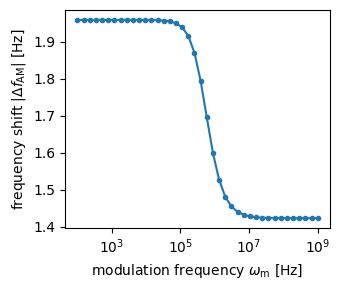

In [70]:
figs['07'] = plotme2(omega_m_array, df_array['III'])

## Type II sample

In [60]:
%%time

df_array['II'] = np.zeros_like(omega_m_array)

for index, omega_m_ in enumerate(omega_m_array):
    obj['II'].set_alpha(1e-6)
    obj['II'].set_breakpoints(15)
    obj['II'].properties_am(omega_m=omega_m_, omega_am = 250)
    df_array['II'][index] = obj['II'].results['Delta f am [Hz]']

CPU times: user 8.45 s, sys: 1.36 s, total: 9.81 s
Wall time: 5.33 s


In [61]:
df_array['II']

array([-0.24717631, -0.24717631, -0.2471763 , -0.24717629, -0.24717626,
       -0.2471762 , -0.24717605, -0.24717572, -0.24717496, -0.24717321,
       -0.24716923, -0.24716013, -0.24713935, -0.24709191, -0.24698379,
       -0.24673825, -0.24618509, -0.24496127, -0.24235831, -0.23725591,
       -0.22866886, -0.21730145, -0.20612745, -0.19783546, -0.19282367,
       -0.19014349, -0.18879901, -0.18814479, -0.18783046, -0.1876799 ,
       -0.18760763, -0.18757276, -0.1875558 , -0.18754749, -0.18754338,
       -0.18754133, -0.1875403 , -0.18753977, -0.18753951, -0.18753937])

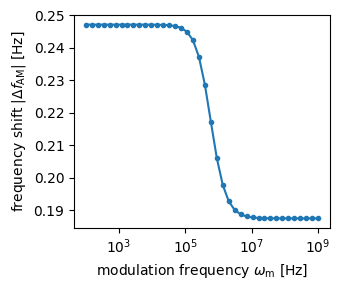

In [71]:
figs['06'] = plotme2(omega_m_array, df_array['II'])

## Type I sample

In [63]:
%%time

df_array['I'] = np.zeros_like(omega_m_array)

for index, omega_m_ in enumerate(omega_m_array):
    obj['I'].set_alpha(1e-6)
    obj['I'].set_breakpoints(15)
    obj['I'].properties_am(omega_m=omega_m_, omega_am = 250)
    df_array['I'][index] = obj['I'].results['Delta f am [Hz]']

CPU times: user 39 s, sys: 6.3 s, total: 45.3 s
Wall time: 23.7 s


In [64]:
df_array['I']

array([-0.15011883, -0.15011882, -0.15011881, -0.15011879, -0.15011875,
       -0.15011871, -0.15011865, -0.15011857, -0.15011847, -0.15011834,
       -0.15011819, -0.15011802, -0.15011782, -0.15011759, -0.15011735,
       -0.15011708, -0.15011681, -0.15011653, -0.15011626, -0.15011601,
       -0.15011579, -0.15011561, -0.15011547, -0.15011537, -0.15011531,
       -0.15011527, -0.15011525, -0.15011524, -0.15011523, -0.15011523,
       -0.15011522, -0.15011522, -0.1501152 , -0.15011517, -0.1501151 ,
       -0.15011497, -0.15011476, -0.15011452, -0.1501143 , -0.15011417])

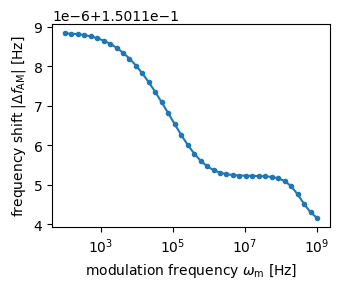

In [72]:
figs['05'] = plotme2(omega_m_array, df_array['I'])

::: {.content-hidden when-format="html"}

# Save the figures

In [ ]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-65.ipynb && open dissipation-theory--Study-65.html
    
:::